<a href="https://colab.research.google.com/github/d0lev/API-Security-Detection/blob/main/challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cisco - Ariel University API Security Detection Challenge 2023
### Imports and global settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_path = "/content/drive/MyDrive/CiscoChallenge/Data/dataset_1_train.json";
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(dataset_path) as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# **Preprocessing**

---
At this step we will engineer the various features in the data set,  It involves transforming data to forms that better relate to the underlying target to be learned. 
In the data set, there are various attacks on the API, for this purpose, we will create a binary column that will describe whether or not any attack was carried out in each record

In [4]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

for column in df.columns[df.isna().any()].tolist():
    df[column] = df[column].fillna('None')

# Any entry that contains a particular attack will be labeled malware.
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign': 
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

In [5]:
df.head(4)

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,127.0.0.1:5000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,127.0.0.1:5000,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign


### **Dataset Description :**

---
For each record in the data set, some different features describe the request and the response headers.

#### **Request Header :**
---
HTTP header that can be used in an HTTP request to provide information about the request context, so that the server can tailor the response.



>>
 
  1. <ins>**Host**</ins> : `specifies the host and port number of the server to which the request is being sent. `

  2. <ins>**User agent**</ins> : `informs the server which browser and operating system the client is using`

  3. <ins>**Accept Encoding**</ins> : `indicates the content encoding that the client can understand.`
      
  4. <ins>**Accept**</ins> :` indicates which content types, expressed as MIME types, the client is able to understand`

  5. <ins>**Connection**</ins> :` indicates whether the network connection stays open after the current transaction finishes.`

  6. <ins>**Accept Langauge**</ins> :` indicates the natural language and locale that the client prefers.`

  7. <ins>**Sec-Fetch-Site**</ins> :`indicates whether a request for a resource is coming from the same origin, the same site or different site.`

  8. <ins>**Sec-Fetch-Mode**</ins> :` indicates the mode of the request.`

  9. <ins>**Sec-Fetch-User**</ins> :` sent for requests initiated by user activation, and its value will always be ?1`

  10. <ins>**Sec-Fetch-Dest**</ins> :`That is the initiator of the original fetch request, which is where/how the fetched data will be used.`

  11. <ins>**Set-Cookie**</ins> :`indicates a cookie that sends from the server to the user agent, so that the user agent can send it back to the server.`

  12. <ins>**Date**</ins> :` indicates the date and time at which the message originated.`

  13. <ins>**Method**</ins> :`A message to the server to indicate the kind of actions to take.`

  14. <ins>**Url**</ins> :`address that contains the information needed to access the server resources.`
      
  15. <ins>**Body**</ins> :`indicates a readable stream of byte data that represents the contents that have been added to the request. `




### **Classes distribution :**

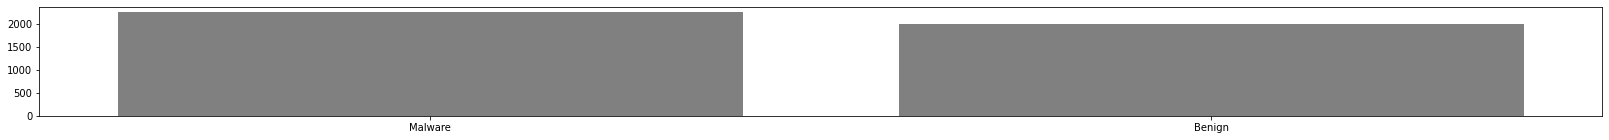

In [6]:
fig = plt.figure(1, figsize=(28,2))
classes_distribution = df['label'].value_counts().to_frame().reset_index().to_numpy()
sns.barplot(x = [classes_distribution[0][0],classes_distribution[1][0]] , y = [classes_distribution[0][1] , classes_distribution[1][1]] , color = "gray")
plt.show()

In [7]:
df.shape

(4282, 26)

### **Feature Enginering :**


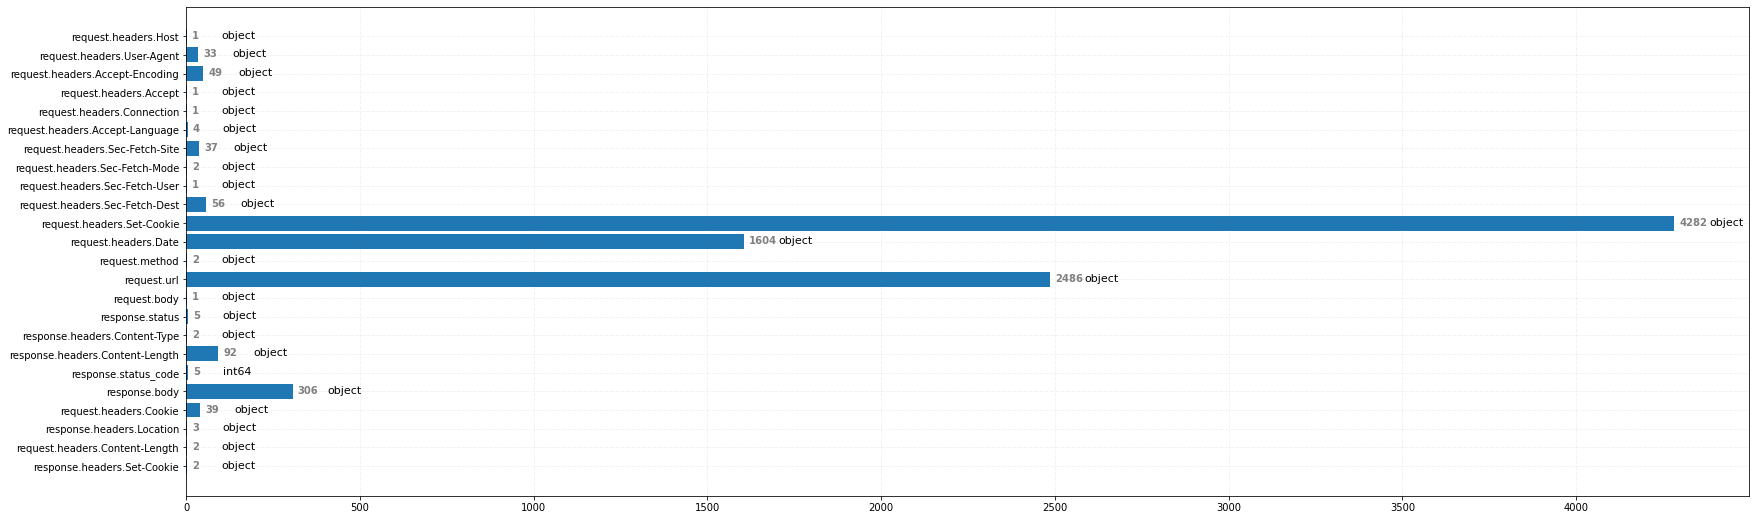

In [8]:
# Iterate through the data set and check for each column what types it contains and their quantities.
features , unique_values = ([],[])
same_value_features = []
for (col_name,col_value) in df.iteritems():
    if (col_name != "label" and col_name != "attack_type"):
        features.append(col_name)
        unique_values.append(len(np.unique(col_value)))
        if(unique_values[-1] == 1):
          # add the columns that contains one value for each record in the dataset
          same_value_features.append(col_name)

counter = 0
fig, ax = plt.subplots(figsize =(28, 9)) 
# Horizontal Bar Plot
ax.barh(features, unique_values)
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.2)
# Show top values
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width() + 15, i.get_y() + 0.5, str(round((i.get_width()), 2)),fontsize = 10, fontweight ='bold', color ='grey')
    col_name = features[counter]
    plt.text(i.get_width() + 100, i.get_y() + 0.5, df[str(col_name)].dtype ,fontsize = 11, color ='black')
    counter = counter + 1

# Show Plot
plt.show()

As you can see, there are five attributes that contain the same value for all records in the dataset:
1. `Host ip` from the request header
2. `HTTP Accept` from the request header
3. `Connection type` from the request header
4. `Sec-Fetch-User` fetch metadata from the request header
5. `Request body` from the request header

It's not useful for building the model because it doesn't provide information that can help distinguish one record from another. In this case, we will remove the features from the dataset.

In [9]:
dataset = df.drop(same_value_features, axis = 1)
dataset.head(4)

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",de-CH,none,same-origin,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",de,none,same-origin,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",de,none,same-origin,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",de-CH,none,same-origin,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign


In [10]:
df['response.headers.Location'].unique().tolist()

['None', 'http://127.0.0.1:5000/post/new/', '/cookielogin']

In [11]:
dataset['response.headers.Set-Cookie'].unique().tolist()

['None',
 'username=gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc29ulJOUKYGUfZSMCHVzZXJuYW1llE5zYi4=; Path=/']

In [12]:
dataset['request.headers.Cookie'].str.contains("gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc29ulJOUKYGUfZSMCHVzZXJuYW1llE5zYi4").sum()
dataset['request.headers.Cookie'].unique().tolist()

['None',
 'username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhbJSTlIytKGV4ZWMoJycnCmltcG9ydCBvcwpvcy5zeXN0ZW0oInBvd2Vyc2hlbGwgZWNobyAnaGVsbG8gd29ybGQnIikKCmZyb20gY29sbGVjdGlvbnMgaW1wb3J0IG5hbWVkdHVwbGUKVXNlciA9IG5hbWVkdHVwbGUoJ1VzZXInLCBbJ3VzZXJuYW1lJ10pCicnJyksIFVzZXIodXNlcm5hbWU9J0NlZHJpYycpKVstMV2UhZRSlC4=; username=gASVKgAAAAAAAACMCF9fbWFpbl9flIwGUGVyc29ulJOUKYGUfZSMCHVzZXJuYW1llE5zYi4=',
 'username=gASVygAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhbJSTlIyuKGV4ZWMoJycnCmltcG9ydCBvcwpvcy5zeXN0ZW0oInBvd2Vyc2hlbGwgZWNobyAnaGVsbG8gd29ybGQnIikKCmZyb20gY29sbGVjdGlvbnMgaW1wb3J0IG5hbWVkdHVwbGUKVXNlciA9IG5hbWVkdHVwbGUoJ1VzZXInLCBbJ3VzZXJuYW1lJ10pCicnJyksIFVzZXIodXNlcm5hbWU9J1NoZW5pdGEnKSlbLTFdlIWUUpQu',
 'username=gASVyAAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhbJSTlIysKGV4ZWMoJycnCmltcG9ydCBvcwpvcy5zeXN0ZW0oInBvd2Vyc2hlbGwgZWNobyAnaGVsbG8gd29ybGQnIikKCmZyb20gY29sbGVjdGlvbnMgaW1wb3J0IG5hbWVkdHVwbGUKVXNlciA9IG5hbWVkdHVwbGUoJ1VzZXInLCBbJ3VzZXJuYW1lJ10pCicnJyksIFVzZXIodXNlcm5hbWU9J0pld2VsJykpWy0xXZSFlFKULg==',
 'username=gAS

In [13]:
def cookie_parsing(dataframe):
  cookies = dataset['request.headers.Cookie'].tolist()
  columns = ['user1','user2',"n_users"]
  cookie_dataset = []

  for cookie in cookies:
    if cookie == "None":
      cookie_dataset.append([0,0,0])
    else:
      cookie = cookie.replace("username=","")
      cookie_p = cookie.split(";")
      if len(cookie_p) == 2:
        cookie_p.append(2)
        cookie_dataset.append(cookie_p)
      else:
        cookie_p.append(1)
        cookie_p.append(0)
        cookie_dataset.append(cookie_p)

  cookie_dataset = pd.DataFrame(cookie_dataset, columns = columns,dtype = str) 

  return cookie_dataset

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk import flatten

from urllib.parse import urlparse

def url_parsing(dataframe):
  urls = dataframe['request.url'].tolist()
  columns = ["scheme","netloc","path","params","query","fragment"]
  url_dataset = []

  for url in urls:
    parsed_url = []
    url_p = urlparse(url)
    for index in range(len(url_p)):
        parsed_url.append(url_p[index])
    
    flattened_list = flatten(parsed_url)
    url_dataset.append(flattened_list)

  url_dataset = pd.DataFrame(url_dataset, columns = columns,dtype = str) 
  url_dataset.drop(['params','fragment'],axis = 1,inplace = True)

  return url_dataset

In [15]:
from urllib.parse import urlparse
import gensim

# parsing_url_dataset method create an embedding vector for each url by his features which parse by urlparse library.
def parsing_url_dataset(dataframe):
  urls = dataframe['request.url'].tolist()
  columns = ["scheme","netloc","path","params","query","fragment"]
  url_dataset = []

  for url in urls:
    parsed_url = []
    url_p = urlparse(url)
    for index in range(len(url_p)):
      parsed_url.append(url_p[index])

    url_dataset.append(parsed_url)

  url_dataset = pd.DataFrame(url_dataset, columns = columns,dtype = object) 
  url_dataset.drop(['params','fragment'],axis = 1,inplace = True)

  path_split = url_dataset['path'].str.split('/', expand=True)
  query_split = url_dataset['query'].str.split('=', expand=True)
  url_dataset.drop(['path','query'],axis = 1, inplace = True)
  url_dataset = url_dataset.merge(path_split,left_index=True, right_index=True)
  url_dataset = url_dataset.merge(query_split,left_index=True, right_index=True)
  url_dataset = url_dataset.fillna(0)

  url_tokens = []
  for tokens in url_dataset.to_numpy():
    tokens_withoutzero = list(filter(lambda num: num != 0, tokens))
    url_tokens.append(tokens_withoutzero)

  max_length = max(len(x) for x in url_tokens)
  print(max_length)
  

  for url_token in url_tokens:  
    while len(url_token) < max_length:
        url_token.append("<PAD>")

  embedding_vector_size = 64
  model = gensim.models.Word2Vec(url_tokens, size= embedding_vector_size, window = 5, min_count = 1, workers= 4)
  new_url_vectors = [model.wv[tokens] for tokens in url_tokens]
  new_url_vectors = np.array(new_url_vectors)

  new_url_vectors = new_url_vectors.reshape(dataframe.shape[0], embedding_vector_size * max_length)

  columns = []
  col_name = "url_embedding "
  for i in range (len(new_url_vectors[0])):
    columns.append(col_name + str(i))

  embeddings = pd.DataFrame(new_url_vectors, columns = columns)
  return embeddings


In [16]:
def dataset_arrange(dataframe , embeddings ,index):
  first_n_column  = dataframe.iloc[: , : index]
  second_n_column = dataframe.iloc[: ,index + 1:]
  first_n_column = first_n_column.join(embeddings)
  dataframe = first_n_column.join(second_n_column)

  return dataframe

The `response.headers.Content-Length` feature contains multiple string that represents the length of the content that send from the host, therfore we will convert them to numeric values.

In [17]:
def content_length_numeric(dataframe):
  columns = ['response.headers.Content-Length','response.status_code']
  for col_name in columns:
      dataframe[col_name] = pd.to_numeric(dataframe[col_name])
  return dataframe

There are some features that contain in their content two different types of information, one with a URL address and the other without. We will try to turn these columns into numeric values by setting 1 for a record that contains a URL in the same feature, and 0 otherwise.

In [18]:
def contain_url(dataframe):
  columns = ['request.headers.Accept-Encoding','request.headers.Sec-Fetch-Dest','request.headers.Sec-Fetch-Site']


  for col_name in columns:
      dataframe[col_name] = np.where(dataframe[col_name].str.contains("jndi"), 1, 0)

  return dataframe

### **Dealing with missing values :**


In [19]:
means = df.isnull().mean()
percentages = means[means > 0].round(4).mul(100).sort_values(ascending=False)
percentages

Series([], dtype: float64)

> ### Dealing with categorical features

In [20]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import xgboost as xgb

In [21]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer

# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = [
                'request.method',
                'request.headers.Accept-Language',
                'response.headers.Content-Type',
                'request.headers.Sec-Fetch-Site',
                'n_users',
                'request.headers.Sec-Fetch-Mode',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'user1','user2','scheme','netloc','path','query',
                    'response.headers.Location',
                    'request.headers.Set-Cookie',
                    'response.body',
                    'request.headers.Content-Length',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = ['request.headers.Date','response.status']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    cookies = cookie_parsing(df)
    urls = url_parsing(df)
    df = dataset_arrange(df , cookies ,df.columns.get_loc("request.headers.Cookie"))
    df = dataset_arrange(df , urls ,df.columns.get_loc("request.url"))
    df = contain_url(df) ## create a column that represent indicator for url in the accept encoding
    df = content_length_numeric(df)
    # df = one_hot_content_type(df)

    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=2)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

In [22]:
df = vectorize_df(dataset)

In [23]:
##save snapshot:
df.to_csv("/content/drive/MyDrive/CiscoChallenge/df.csv" , index = False)

In [24]:
df = pd.read_csv("/content/drive/MyDrive/CiscoChallenge/df.csv")

In [25]:
df.head(4)

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.method,scheme,netloc,path,query,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,user1,user2,n_users,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,0.000000,0,1,0,0,0,-0.554700,0,1.0,0.0,-0.447214,0.0,0,72,200,0.447214,0.0,0.0,0,-1.0,-1.0,-1.0,Directory Traversal,Malware
1,-0.948683,0,0,0,0,0,-0.554700,0,1.0,0.0,-0.707107,0.0,0,41,404,0.894427,0.0,0.0,0,-1.0,-1.0,-1.0,Benign,Benign
2,-0.894427,0,0,0,0,0,-0.447214,0,1.0,0.0,1.000000,0.0,1,105,200,0.000000,-1.0,-1.0,1,-1.0,-1.0,-1.0,Cookie Injection,Malware
3,-0.832050,0,1,0,0,0,-0.371391,0,1.0,0.0,0.707107,0.0,0,30,404,0.894427,0.0,0.0,0,-1.0,-1.0,-1.0,Benign,Benign


In [26]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

X = df.drop(['label','attack_type'],axis=1)
columns = X.columns
X = np.nan_to_num(X)
y = df['label']
X = (X-X.min())/(X.max()-X.min())

# k tells k top features to be selected
# Score function Chi2 tells the feature to be selected using Chi Square
test = SelectKBest(score_func=chi2, k = 18)
fit = test.fit(X, y)

In [27]:
test.get_support()

array([False,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False])

In [28]:
delete_features = pd.DataFrame({'columns': columns, 'Kept': test.get_support()})
delete_features = delete_features[(delete_features['Kept'] == False)]['columns'].to_list()
df.drop(delete_features , axis = 1 , inplace = True)

In [29]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   request.headers.Accept-Encoding  4282 non-null   int64  
 1   request.headers.Accept-Language  4282 non-null   int64  
 2   request.headers.Sec-Fetch-Site   4282 non-null   int64  
 3   request.headers.Sec-Fetch-Mode   4282 non-null   int64  
 4   request.headers.Sec-Fetch-Dest   4282 non-null   int64  
 5   request.headers.Set-Cookie       4282 non-null   float64
 6   request.method                   4282 non-null   int64  
 7   path                             4282 non-null   float64
 8   query                            4282 non-null   float64
 9   response.headers.Content-Type    4282 non-null   int64  
 10  response.headers.Content-Length  4282 non-null   int64  
 11  response.status_code             4282 non-null   int64  
 12  response.body       

In [30]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.
features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')

print(features_list)
print(len(features_list))
# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

['request.headers.Accept-Encoding', 'request.headers.Accept-Language', 'request.headers.Sec-Fetch-Site', 'request.headers.Sec-Fetch-Mode', 'request.headers.Sec-Fetch-Dest', 'request.headers.Set-Cookie', 'request.method', 'path', 'query', 'response.headers.Content-Type', 'response.headers.Content-Length', 'response.status_code', 'response.body', 'user1', 'user2', 'n_users', 'response.headers.Location', 'request.headers.Content-Length']
18


request.headers.Accept-Encoding      int64
request.headers.Accept-Language      int64
request.headers.Sec-Fetch-Site       int64
request.headers.Sec-Fetch-Mode       int64
request.headers.Sec-Fetch-Dest       int64
request.headers.Set-Cookie         float64
request.method                       int64
path                               float64
query                              float64
response.headers.Content-Type        int64
response.headers.Content-Length      int64
response.status_code                 int64
response.body                      float64
user1                              float64
user2                              float64
n_users                              int64
response.headers.Location          float64
request.headers.Content-Length     float64
attack_type                         object
label                               object
dtype: object

## Train test split

In [31]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(3425, 18) (3425,)
(857, 18) (857,)


Counter({'Malware': 2264, 'Benign': 2018})

## Model choosing and fitting

In [32]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=45)
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1614), ('Malware', 1811)]


## Result printout

              precision    recall  f1-score   support

      Benign    0.94811   0.99505   0.97101       404
     Malware    0.99538   0.95143   0.97291       453

    accuracy                        0.97200       857
   macro avg    0.97175   0.97324   0.97196       857
weighted avg    0.97310   0.97200   0.97202       857



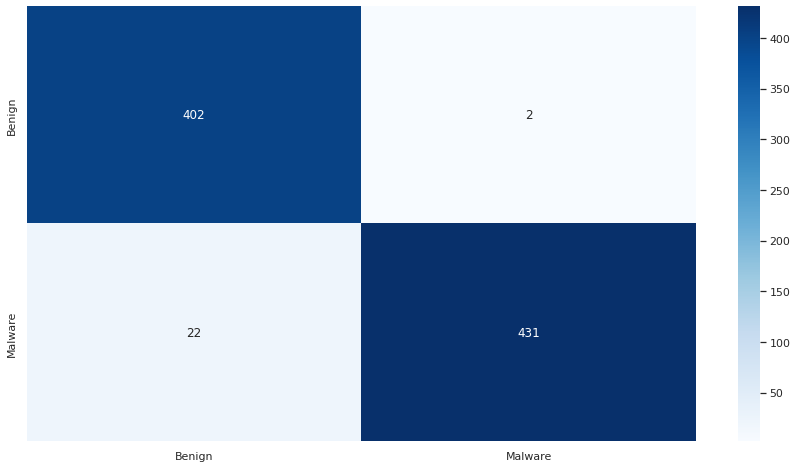

In [33]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [36]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open("/content/drive/MyDrive/CiscoChallenge/Data/dataset_1_val.json") as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
test_df.drop(same_value_features ,axis=1, inplace=True )

for column in test_df.columns[test_df.isna().any()].tolist():
    test_df[column] = test_df[column].fillna('None')


test_df = vectorize_df(test_df)
test_df.drop(delete_features , axis = 1 , inplace = True)
# Predict with your model
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)

In [38]:
malware = 0
benign = 0
for p in predictions:
  if p == "Malware":
     malware = malware + 1
  else:
     benign = benign + 1

In [39]:
print(malware)
print(benign)

356
399


# Save your predictions

In [40]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'/content/drive/MyDrive/CiscoChallenge/dataset_1_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')